# 08 - Scaling Policy Design

This notebook designs and tests autoscaling policies:

1. **Policy Configuration** - Thresholds, cooldown, hysteresis
2. **Policy Testing** - Validate behavior on sample data
3. **Reactive vs Predictive** - Compare policy types

In [1]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Project imports
from src.scaling.config import ScalingConfig, CONSERVATIVE_CONFIG, AGGRESSIVE_CONFIG, BALANCED_CONFIG
from src.scaling.policy import ScalingPolicy, ScalingAction, ReactivePolicy, PredictivePolicy
from src.scaling.simulator import CostSimulator, SimulationMetrics

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"Project root: {project_root}")

Project root: c:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Data

In [2]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"

# Load test data for validation
df_test = pd.read_parquet(PROCESSED_DIR / "test_features_5m.parquet")
df_train = pd.read_parquet(PROCESSED_DIR / "train_features_5m.parquet")

# Extract load data
test_loads = df_test['request_count'].values
test_timestamps = pd.to_datetime(df_test['timestamp'])

train_loads = df_train['request_count'].values
train_timestamps = pd.to_datetime(df_train['timestamp'])

print(f"Test data: {len(test_loads)} periods")
print(f"Train data: {len(train_loads)} periods")
print(f"\nTest load stats:")
print(f"  Mean: {np.mean(test_loads):.0f} requests/5min")
print(f"  Max: {np.max(test_loads):.0f} requests/5min")
print(f"  Min: {np.min(test_loads):.0f} requests/5min")

Test data: 2592 periods
Train data: 15264 periods

Test load stats:
  Mean: 203 requests/5min
  Max: 654 requests/5min
  Min: 0 requests/5min


## 2. Scaling Configuration

In [3]:
# Create custom configuration
config = ScalingConfig(
    min_servers=1,
    max_servers=20,
    requests_per_server=100,  # Each server handles 100 requests per 5-min
    
    scale_out_threshold=0.80,  # Scale out at 80% utilization
    scale_in_threshold=0.30,   # Scale in at 30% utilization
    
    scale_out_consecutive=3,   # 3 consecutive periods (15 min) before scale out
    scale_in_consecutive=6,    # 6 consecutive periods (30 min) before scale in
    
    cooldown_minutes=5,        # 5 min cooldown between scaling actions
    
    scale_out_increment=2,     # Add 2 servers when scaling out
    scale_in_decrement=1,      # Remove 1 server when scaling in
    
    cost_per_server_per_hour=0.10,  # $0.10 per server per hour
    time_window_minutes=5,     # 5-minute data
)

print("Scaling Configuration:")
for key, value in config.to_dict().items():
    print(f"  {key}: {value}")

Scaling Configuration:
  min_servers: 1
  max_servers: 20
  requests_per_server: 100
  scale_out_threshold: 0.8
  scale_in_threshold: 0.3
  scale_out_consecutive: 3
  scale_in_consecutive: 6
  cooldown_minutes: 5
  scale_out_increment: 2
  scale_in_decrement: 1
  cost_per_server_per_hour: 0.1
  time_window_minutes: 5


In [4]:
# Calculate required servers for different load levels
load_levels = [100, 200, 300, 500, 800, 1000, 1500]

print("\nRequired Servers for Different Load Levels:")
print(f"{'Load':>8} | {'Required Servers':>15} | {'Utilization @ Servers':>20}")
print("-" * 50)
for load in load_levels:
    required = config.get_required_servers(load)
    util = config.get_utilization(load, required)
    print(f"{load:>8} | {required:>15} | {util:>20.1%}")


Required Servers for Different Load Levels:
    Load | Required Servers | Utilization @ Servers
--------------------------------------------------
     100 |               2 |                50.0%
     200 |               3 |                66.7%
     300 |               5 |                60.0%
     500 |               8 |                62.5%
     800 |              12 |                66.7%
    1000 |              15 |                66.7%
    1500 |              20 |                75.0%


## 3. Policy Testing

In [5]:
# Create scaling policy
policy = ScalingPolicy(config)

print(f"Initial servers: {policy.get_current_servers()}")

Initial servers: 1


In [6]:
# Test policy with sample loads
sample_loads = [50, 100, 150, 200, 250, 300, 350, 400, 300, 200, 100, 50]
start_time = datetime(2023, 1, 1, 8, 0, 0)

print("Testing Policy with Sample Loads:")
print("=" * 80)

policy.reset(initial_servers=2)

for i, load in enumerate(sample_loads):
    ts = start_time + timedelta(minutes=i * 5)
    decision = policy.recommend(load, ts)
    
    print(f"[{ts.strftime('%H:%M')}] Load={load:4d} | Servers={decision.current_servers} | "
          f"Util={decision.utilization:.1%} | Action={decision.action.value:10s} | {decision.reason}")

Testing Policy with Sample Loads:
[08:00] Load=  50 | Servers=2 | Util=25.0% | Action=hold       | waiting_scale_in_1/6
[08:05] Load= 100 | Servers=2 | Util=50.0% | Action=hold       | normal_utilization
[08:10] Load= 150 | Servers=2 | Util=75.0% | Action=hold       | normal_utilization
[08:15] Load= 200 | Servers=2 | Util=100.0% | Action=hold       | waiting_scale_out_1/3
[08:20] Load= 250 | Servers=2 | Util=125.0% | Action=hold       | waiting_scale_out_2/3
[08:25] Load= 300 | Servers=2 | Util=150.0% | Action=scale_out  | high_utilization_3_periods
[08:30] Load= 350 | Servers=4 | Util=87.5% | Action=hold       | waiting_scale_out_1/3
[08:35] Load= 400 | Servers=4 | Util=100.0% | Action=hold       | waiting_scale_out_2/3
[08:40] Load= 300 | Servers=4 | Util=75.0% | Action=hold       | normal_utilization
[08:45] Load= 200 | Servers=4 | Util=50.0% | Action=hold       | normal_utilization
[08:50] Load= 100 | Servers=4 | Util=25.0% | Action=hold       | waiting_scale_in_1/6
[08:55] Load= 

## 4. Run Simulation on Test Data

In [7]:
# Create simulator
simulator = CostSimulator(config)

# Run simulation on test data
policy = ScalingPolicy(config)
metrics = simulator.simulate(
    loads=test_loads,
    policy=policy,
    timestamps=test_timestamps.tolist(),
    initial_servers=3
)

print(metrics)

Simulation Results:
  Total Cost: $96.61
  Avg Cost/Hour: $0.4473
  Avg Servers: 4.47
  Avg Utilization: 44.8%
  SLA Violations: 10 (0.4%)
  Scaling Events: 44 (out: 16, in: 28)


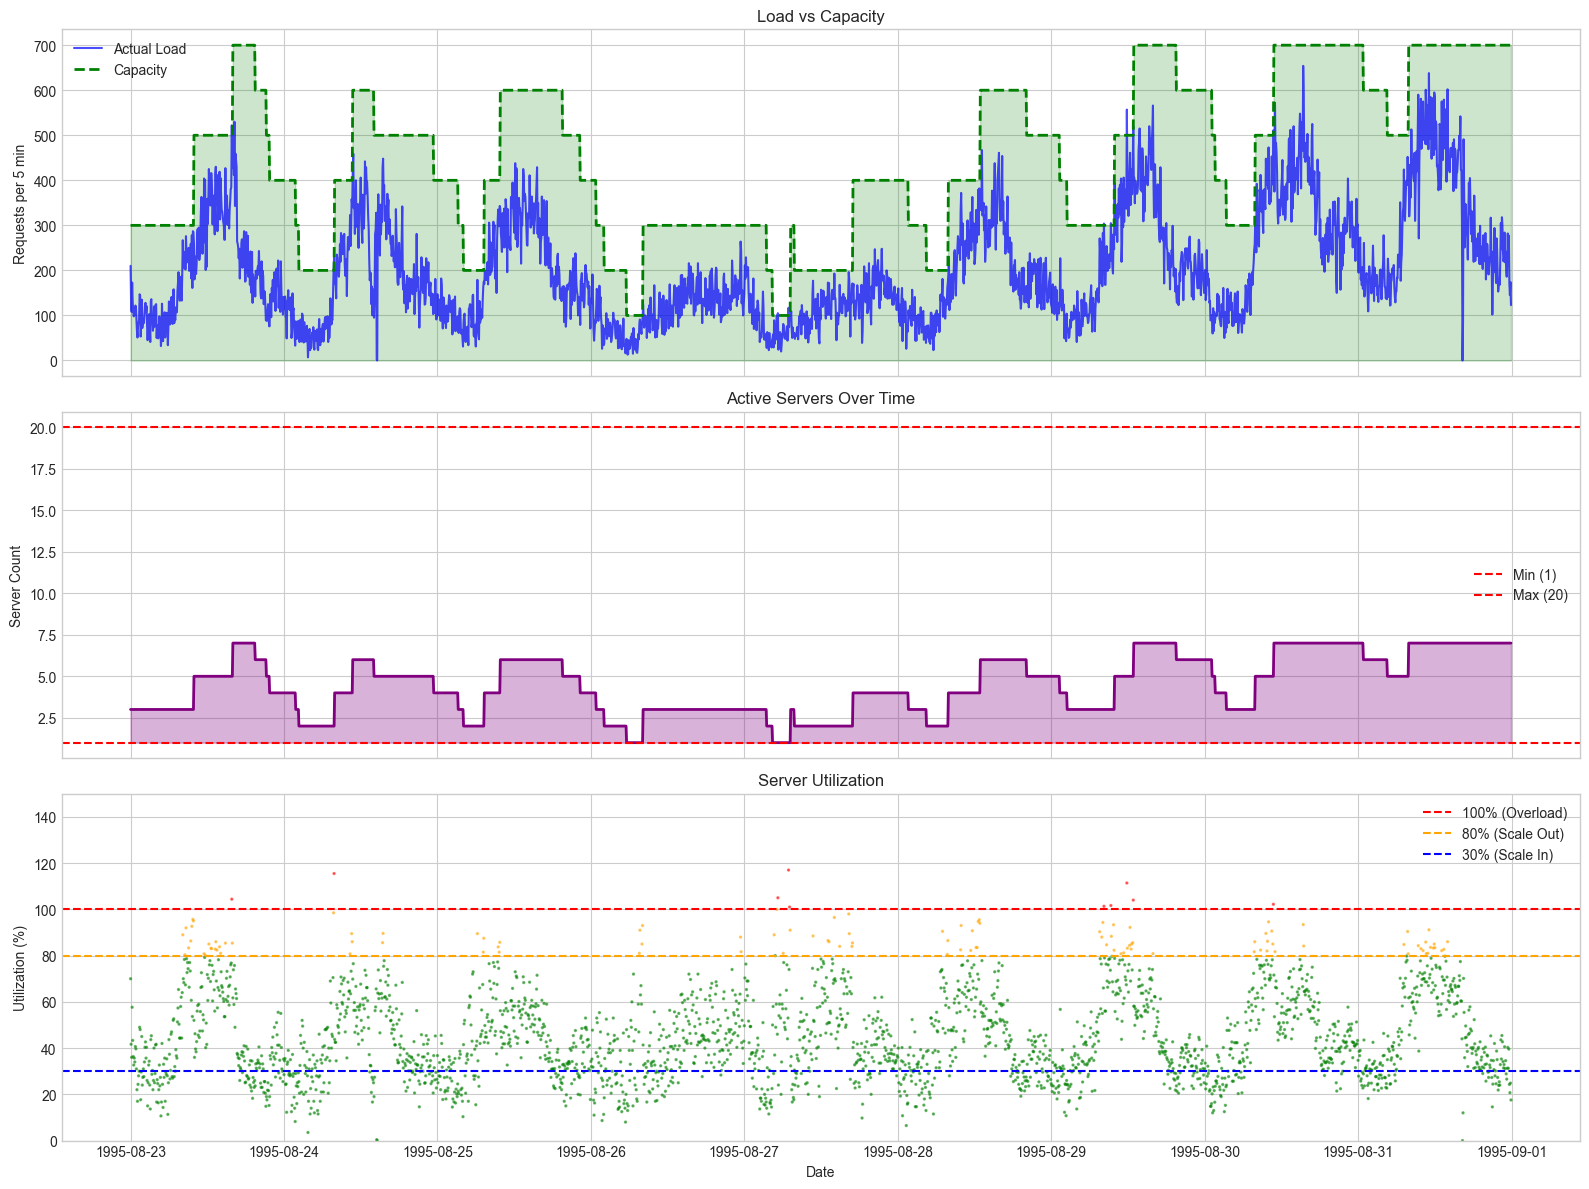

In [8]:
# Visualize simulation results
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Load and capacity
ax = axes[0]
ax.plot(test_timestamps, test_loads, label='Actual Load', color='blue', alpha=0.7)
capacity = np.array(metrics.servers_over_time) * config.requests_per_server
ax.plot(test_timestamps, capacity, label='Capacity', color='green', linestyle='--', linewidth=2)
ax.fill_between(test_timestamps, 0, capacity, alpha=0.2, color='green')
ax.set_ylabel('Requests per 5 min')
ax.set_title('Load vs Capacity')
ax.legend()

# Server count
ax = axes[1]
ax.plot(test_timestamps, metrics.servers_over_time, color='purple', linewidth=2)
ax.fill_between(test_timestamps, config.min_servers, metrics.servers_over_time, alpha=0.3, color='purple')
ax.axhline(config.min_servers, color='red', linestyle='--', label=f'Min ({config.min_servers})')
ax.axhline(config.max_servers, color='red', linestyle='--', label=f'Max ({config.max_servers})')
ax.set_ylabel('Server Count')
ax.set_title('Active Servers Over Time')
ax.legend()

# Utilization
ax = axes[2]
utilization = np.array(metrics.utilization_over_time)
colors = ['red' if u > 1 else 'orange' if u > 0.8 else 'green' for u in utilization]
ax.scatter(test_timestamps, utilization * 100, c=colors, s=2, alpha=0.5)
ax.axhline(100, color='red', linestyle='--', label='100% (Overload)')
ax.axhline(80, color='orange', linestyle='--', label='80% (Scale Out)')
ax.axhline(30, color='blue', linestyle='--', label='30% (Scale In)')
ax.set_ylabel('Utilization (%)')
ax.set_xlabel('Date')
ax.set_title('Server Utilization')
ax.legend()
ax.set_ylim(0, max(150, max(utilization) * 100 + 10))

plt.tight_layout()
plt.show()

## 5. Compare Policy Configurations

In [9]:
# Define different configurations
configs = {
    'Conservative': CONSERVATIVE_CONFIG,
    'Balanced': BALANCED_CONFIG,
    'Aggressive': AGGRESSIVE_CONFIG,
}

# Print configuration comparison
print("Configuration Comparison:")
print("=" * 80)
print(f"{'Parameter':<25} | {'Conservative':>12} | {'Balanced':>12} | {'Aggressive':>12}")
print("-" * 80)

params = ['scale_out_threshold', 'scale_in_threshold', 'scale_out_consecutive', 
          'scale_in_consecutive', 'cooldown_minutes', 'scale_out_increment', 'scale_in_decrement']

for param in params:
    values = [getattr(c, param) for c in configs.values()]
    print(f"{param:<25} | {values[0]:>12} | {values[1]:>12} | {values[2]:>12}")

Configuration Comparison:
Parameter                 | Conservative |     Balanced |   Aggressive
--------------------------------------------------------------------------------
scale_out_threshold       |          0.7 |          0.8 |         0.85
scale_in_threshold        |          0.2 |          0.3 |          0.4
scale_out_consecutive     |            5 |            3 |            2
scale_in_consecutive      |           10 |            6 |            4
cooldown_minutes          |           10 |            5 |            3
scale_out_increment       |            1 |            2 |            3
scale_in_decrement        |            1 |            1 |            2


In [10]:
# Run simulations for each configuration
results = {}

for name, cfg in configs.items():
    simulator = CostSimulator(cfg)
    policy = ScalingPolicy(cfg)
    results[name] = simulator.simulate(
        loads=test_loads,
        policy=policy,
        timestamps=test_timestamps.tolist(),
        initial_servers=3
    )

# Also add fixed strategies
for fixed_servers in [5, 10, 15]:
    results[f'Fixed ({fixed_servers} servers)'] = simulator.simulate_fixed(test_loads, fixed_servers)

print("Simulation Results:")
print("=" * 100)
print(f"{'Strategy':<25} | {'Cost':>10} | {'Avg Servers':>12} | {'Avg Util':>10} | {'SLA Viol':>10} | {'Events':>8}")
print("-" * 100)

for name, metrics in results.items():
    print(f"{name:<25} | ${metrics.total_cost:>9.2f} | {metrics.avg_servers:>12.2f} | "
          f"{metrics.avg_utilization:>9.1%} | {metrics.sla_violations:>10} | {metrics.scaling_events:>8}")

Simulation Results:
Strategy                  |       Cost |  Avg Servers |   Avg Util |   SLA Viol |   Events
----------------------------------------------------------------------------------------------------
Conservative              | $   107.82 |         4.99 |     41.8% |         13 |       27
Balanced                  | $    96.61 |         4.47 |     44.8% |         10 |       44
Aggressive                | $    85.48 |         3.96 |     52.4% |         35 |      115
Fixed (5 servers)         | $   108.00 |         5.00 |     40.6% |         52 |        0
Fixed (10 servers)        | $   216.00 |        10.00 |     20.3% |          0 |        0
Fixed (15 servers)        | $   324.00 |        15.00 |     13.5% |          0 |        0


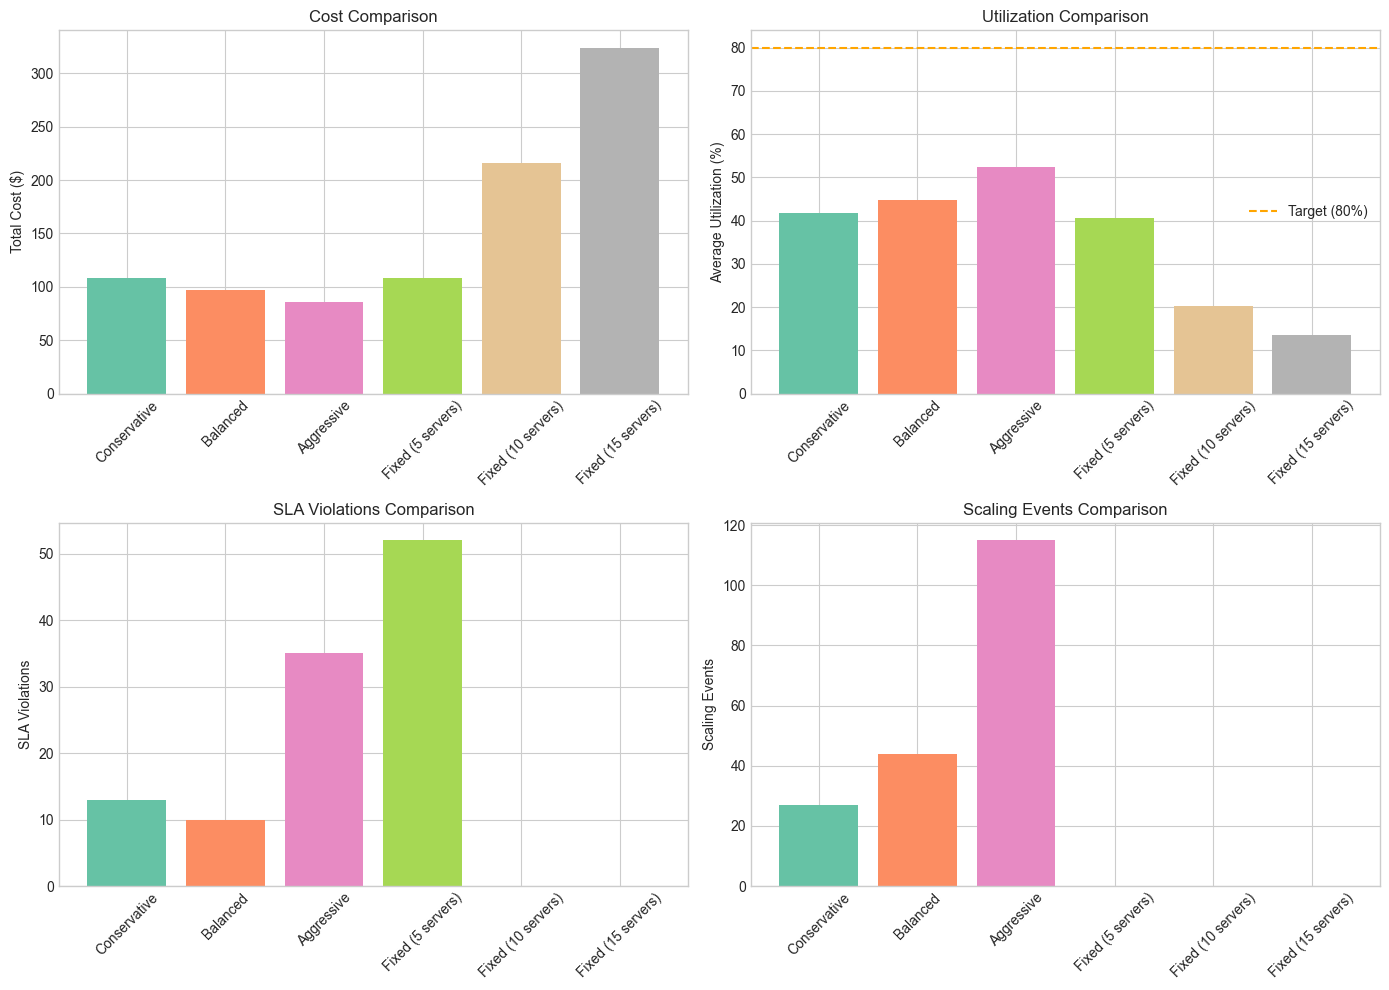

In [11]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

strategies = list(results.keys())
colors = plt.cm.Set2(np.linspace(0, 1, len(strategies)))

# Cost comparison
ax = axes[0, 0]
costs = [results[s].total_cost for s in strategies]
bars = ax.bar(strategies, costs, color=colors)
ax.set_ylabel('Total Cost ($)')
ax.set_title('Cost Comparison')
ax.tick_params(axis='x', rotation=45)

# Average utilization
ax = axes[0, 1]
utils = [results[s].avg_utilization * 100 for s in strategies]
ax.bar(strategies, utils, color=colors)
ax.axhline(80, color='orange', linestyle='--', label='Target (80%)')
ax.set_ylabel('Average Utilization (%)')
ax.set_title('Utilization Comparison')
ax.tick_params(axis='x', rotation=45)
ax.legend()

# SLA violations
ax = axes[1, 0]
violations = [results[s].sla_violations for s in strategies]
ax.bar(strategies, violations, color=colors)
ax.set_ylabel('SLA Violations')
ax.set_title('SLA Violations Comparison')
ax.tick_params(axis='x', rotation=45)

# Scaling events
ax = axes[1, 1]
events = [results[s].scaling_events for s in strategies]
ax.bar(strategies, events, color=colors)
ax.set_ylabel('Scaling Events')
ax.set_title('Scaling Events Comparison')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Reactive vs Predictive Policy

In [12]:
# Compare reactive and predictive policies
reactive_policy = ReactivePolicy(config)
predictive_policy = PredictivePolicy(config, forecast_horizon=6, safety_margin=0.1)

# Simulate reactive
reactive_metrics = simulator.simulate(
    loads=test_loads,
    policy=reactive_policy,
    timestamps=test_timestamps.tolist(),
    initial_servers=3
)

print("Reactive Policy Results:")
print(reactive_metrics)

# For predictive, we would need forecasts - use simple moving average as proxy
print("\nNote: Predictive policy requires model forecasts.")
print("In production, integrate with LightGBM predictions for proactive scaling.")

Reactive Policy Results:
Simulation Results:
  Total Cost: $94.41
  Avg Cost/Hour: $0.4371
  Avg Servers: 4.37
  Avg Utilization: 45.7%
  SLA Violations: 0 (0.0%)
  Scaling Events: 160 (out: 54, in: 106)

Note: Predictive policy requires model forecasts.
In production, integrate with LightGBM predictions for proactive scaling.


## 7. Scaling Behavior Visualization

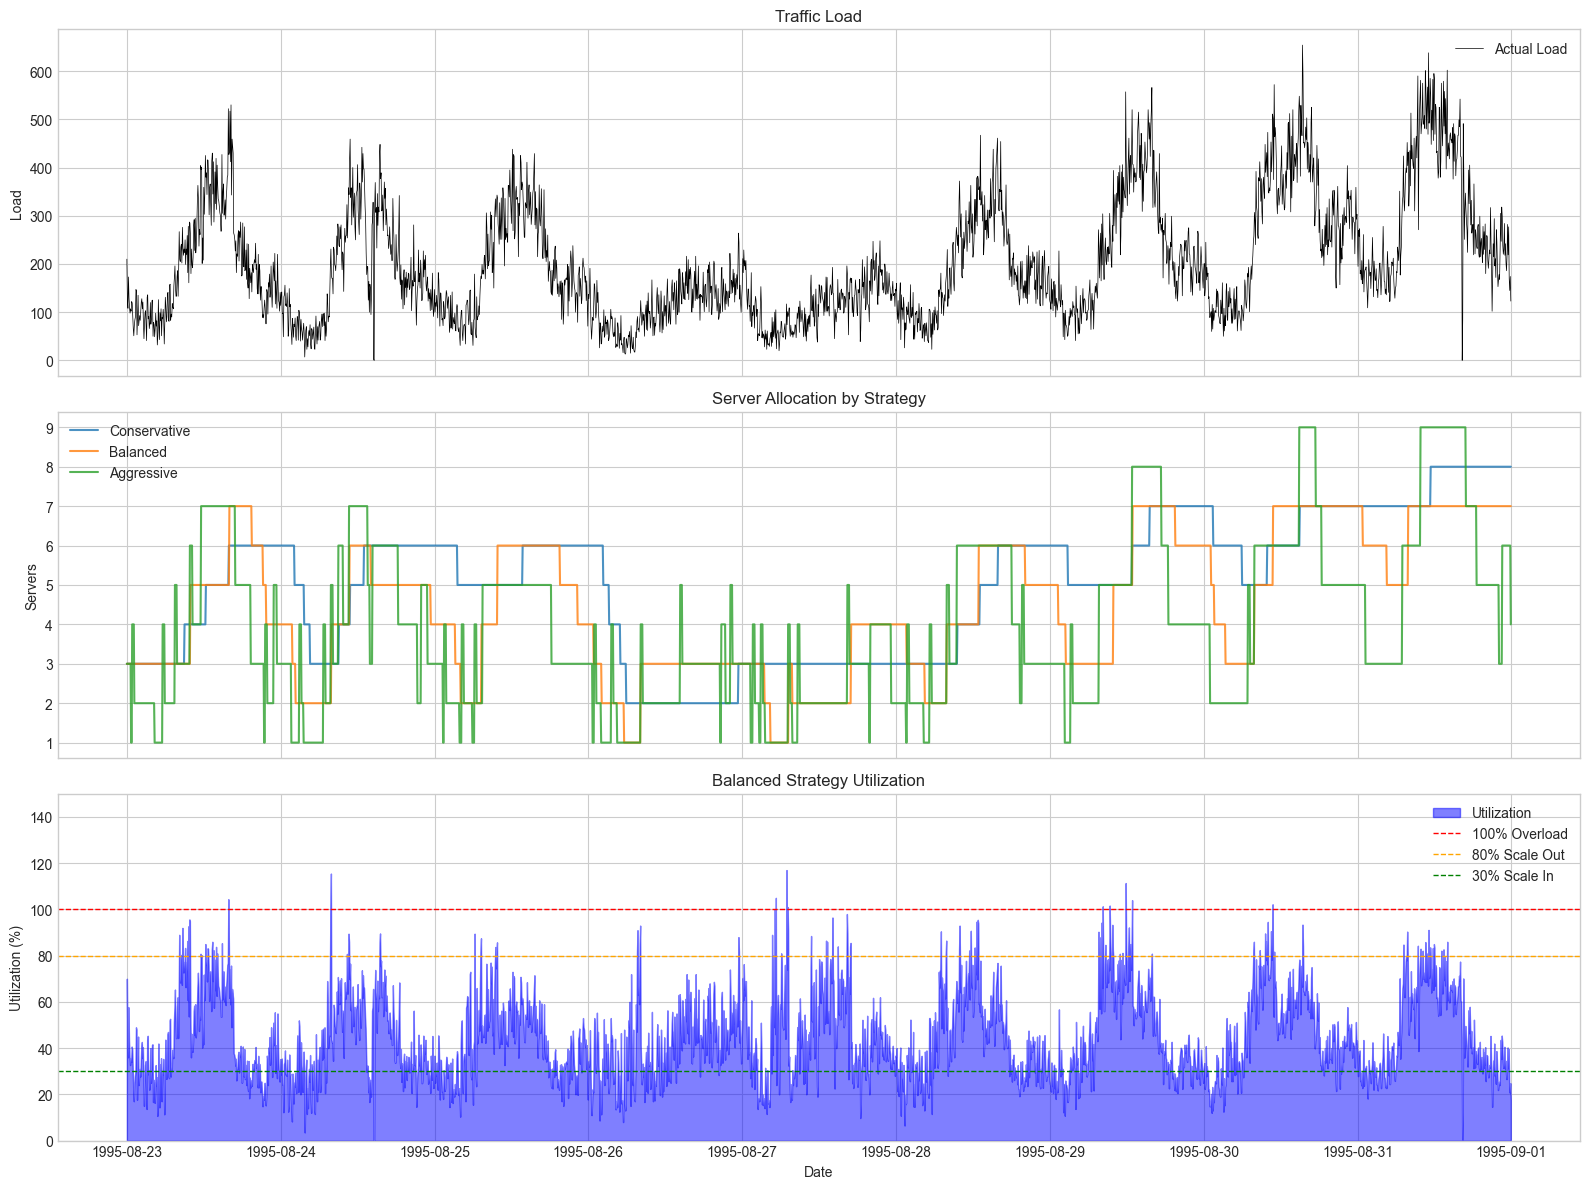

In [13]:
# Compare server allocation across strategies
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Load
ax = axes[0]
ax.plot(test_timestamps, test_loads, color='black', linewidth=0.5, label='Actual Load')
ax.set_ylabel('Load')
ax.set_title('Traffic Load')
ax.legend()

# Servers for different strategies
ax = axes[1]
for i, (name, metrics) in enumerate(results.items()):
    if 'Fixed' not in name:  # Only show scaling policies
        ax.plot(test_timestamps, metrics.servers_over_time, label=name, alpha=0.8)
ax.set_ylabel('Servers')
ax.set_title('Server Allocation by Strategy')
ax.legend()

# Utilization for balanced strategy
ax = axes[2]
balanced_util = np.array(results['Balanced'].utilization_over_time) * 100
ax.fill_between(test_timestamps, 0, balanced_util, alpha=0.5, color='blue', label='Utilization')
ax.axhline(100, color='red', linestyle='--', linewidth=1, label='100% Overload')
ax.axhline(80, color='orange', linestyle='--', linewidth=1, label='80% Scale Out')
ax.axhline(30, color='green', linestyle='--', linewidth=1, label='30% Scale In')
ax.set_ylabel('Utilization (%)')
ax.set_xlabel('Date')
ax.set_title('Balanced Strategy Utilization')
ax.legend()
ax.set_ylim(0, 150)

plt.tight_layout()
plt.show()

## 8. Summary

In [14]:
print("=" * 60)
print("SCALING POLICY DESIGN SUMMARY")
print("=" * 60)

print("\n1. CONFIGURATION PARAMETERS")
print(f"   - Capacity per server: {config.requests_per_server} requests/5min")
print(f"   - Server range: {config.min_servers} - {config.max_servers}")
print(f"   - Scale out threshold: {config.scale_out_threshold:.0%}")
print(f"   - Scale in threshold: {config.scale_in_threshold:.0%}")
print(f"   - Cost per server: ${config.cost_per_server_per_hour}/hour")

print("\n2. BEST STRATEGY (by cost-efficiency)")
best_scaling = min(
    [(k, v) for k, v in results.items() if 'Fixed' not in k],
    key=lambda x: x[1].total_cost if x[1].sla_violations < 100 else float('inf')
)
print(f"   Strategy: {best_scaling[0]}")
print(f"   Total Cost: ${best_scaling[1].total_cost:.2f}")
print(f"   Avg Utilization: {best_scaling[1].avg_utilization:.1%}")
print(f"   SLA Violations: {best_scaling[1].sla_violations}")

print("\n3. COST SAVINGS vs FIXED MAX")
fixed_max = results.get('Fixed (15 servers)', results.get('Fixed (10 servers)'))
if fixed_max:
    savings = fixed_max.total_cost - best_scaling[1].total_cost
    savings_pct = (savings / fixed_max.total_cost) * 100
    print(f"   Savings: ${savings:.2f} ({savings_pct:.1f}%)")

print("\n4. NEXT STEPS")
print("   - Run detailed cost simulation (notebook 09)")
print("   - Optimize thresholds via grid search")
print("   - Integrate with prediction model for proactive scaling")

SCALING POLICY DESIGN SUMMARY

1. CONFIGURATION PARAMETERS
   - Capacity per server: 100 requests/5min
   - Server range: 1 - 20
   - Scale out threshold: 80%
   - Scale in threshold: 30%
   - Cost per server: $0.1/hour

2. BEST STRATEGY (by cost-efficiency)
   Strategy: Aggressive
   Total Cost: $85.48
   Avg Utilization: 52.4%
   SLA Violations: 35

3. COST SAVINGS vs FIXED MAX
   Savings: $238.52 (73.6%)

4. NEXT STEPS
   - Run detailed cost simulation (notebook 09)
   - Optimize thresholds via grid search
   - Integrate with prediction model for proactive scaling


In [15]:
# Save best configuration
import json

MODELS_DIR = project_root / "models"
MODELS_DIR.mkdir(exist_ok=True)

best_config = BALANCED_CONFIG  # Use balanced as default
with open(MODELS_DIR / 'scaling_config.json', 'w') as f:
    json.dump(best_config.to_dict(), f, indent=2)

print(f"Saved scaling config to {MODELS_DIR / 'scaling_config.json'}")

Saved scaling config to c:\Users\Admin\OneDrive\Documents\python\datafollow\models\scaling_config.json


In [16]:
print("\nNotebook completed successfully!")


Notebook completed successfully!
